In [1]:
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.express as px
from IPython.display import display
import os

In [132]:
base_directory = '/content/drive/MyDrive'
# Load dataset
print("\n1. Loading and Preparing Dataset...")
dataset_path = os.path.join(base_directory, 'FYP_Data_PipeLine/BTC_1d.csv')
maindf = pd.read_csv(dataset_path)
model_name = os.path.splitext(os.path.basename(dataset_path))[0]
print(f"\nModel Name: {model_name}")


1. Loading and Preparing Dataset...

Model Name: BTC_1d


In [133]:
print("\nDataset Overview:")
display(maindf.head())
print(f"\nDataset Shape: {maindf.shape}")
# Display dataset info
print("\nDataset Information:")
display(maindf.info())

# Display basic statistics
print("\nBasic Statistics:")
display(maindf.describe())

# Check for null values
print("\nNull Value Check:")
null_df = pd.DataFrame({
    'Column': maindf.columns,
    'Null Count': maindf.isnull().sum(),
    'Null Percentage': (maindf.isnull().sum() / len(maindf) * 100).round(2)
})
display(null_df)


Dataset Overview:


,Open Time,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex
0,2024-07-18 00:00:00,64055.8000,65173.8000,63206.4000,63959.9000,13840486905.3186,1722489893.2227,1.1749,61.0000,50.0000
1,2024-07-19 00:00:00,63960.0000,67362.8000,63266.2000,66627.9000,20380653025.9215,1857912807.6300,1.2257,60.0000,50.0000
2,2024-07-20 00:00:00,66627.9000,67648.7000,66159.1000,67095.6000,8257377670.6534,1953121464.2450,1.1200,74.0000,50.0000
3,2024-07-21 00:00:00,67095.6000,68351.2000,65750.0000,68138.0000,13911463550.0015,1959400894.3200,1.1492,74.0000,50.0000
4,2024-07-22 00:00:00,68138.0000,68459.7000,66538.6000,67499.2000,13023877366.2714,1868374910.3248,1.1664,70.0000,50.0000



Dataset Shape: (187, 10)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open Time            187 non-null    object 
 1   Open                 187 non-null    float64
 2   High                 187 non-null    float64
 3   Low                  187 non-null    float64
 4   Close                187 non-null    float64
 5   Quote Asset Volume   187 non-null    float64
 6   Open Interest (USD)  187 non-null    float64
 7   LSRatio              187 non-null    float64
 8   FearGreedIndex       187 non-null    float64
 9   TwitterIndex         187 non-null    float64
dtypes: float64(9), object(1)
memory usage: 14.7+ KB


None


Basic Statistics:


,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex
count,187.0000,187.0000,187.0000,187.0000,187.0000,187.0000,187.0000,187.0000,187.0000
mean,76117.1920,77785.5000,74625.4230,76341.7096,18977790194.5767,2101427936.6462,1.1888,60.7273,50.0000
std,16914.2378,17360.5623,16571.1329,17032.4985,10449648915.2464,646421010.6505,0.0800,19.5532,0.0000
min,53927.7000,54820.2000,48888.0000,53927.7000,4066497717.5845,1145943945.8334,1.0243,17.0000,50.0000
25%,61571.7500,62629.0500,60168.3500,61571.7500,12865432479.6067,1609408288.6936,1.1263,48.0000,50.0000
50%,67834.4000,68684.9000,66624.5000,67873.8000,17221797609.5618,1960783929.4680,1.1930,70.0000,50.0000
75%,95083.7000,97246.1000,93482.8000,95206.3000,22959064544.1863,2529381497.9812,1.2538,75.0000,50.0000
max,106074.6000,110000.0000,105252.0000,106114.5000,67990070656.1828,3814334484.2120,1.3430,94.0000,50.0000



Null Value Check:


,Column,Null Count,Null Percentage
Open Time,Open Time,0,0.0000
Open,Open,0,0.0000
High,High,0,0.0000
Low,Low,0,0.0000
Close,Close,0,0.0000
Quote Asset Volume,Quote Asset Volume,0,0.0000
Open Interest (USD),Open Interest (USD),0,0.0000
LSRatio,LSRatio,0,0.0000
FearGreedIndex,FearGreedIndex,0,0.0000
TwitterIndex,TwitterIndex,0,0.0000


In [134]:
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Quote Asset Volume',
           'Open Interest (USD)', 'LSRatio', 'FearGreedIndex',
           'TwitterIndex']

print("\n2. Selected features:")
feature_df = pd.DataFrame({'Features': features})
display(feature_df)


2. Selected features:


,Features
0,Open
1,High
2,Low
3,Close
4,Quote Asset Volume
5,Open Interest (USD)
6,LSRatio
7,FearGreedIndex
8,TwitterIndex


In [135]:
# Create feature dataframe
closedf = maindf[['Open Time'] + features].copy()
closedf['Adj Close'] = maindf['Close']  # Target variable

print("\n3. Feature DataFrame Sample:")
display(closedf.head())


3. Feature DataFrame Sample:


,Open Time,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex,Adj Close
0,2024-07-18 00:00:00,64055.8000,65173.8000,63206.4000,63959.9000,13840486905.3186,1722489893.2227,1.1749,61.0000,50.0000,63959.9000
1,2024-07-19 00:00:00,63960.0000,67362.8000,63266.2000,66627.9000,20380653025.9215,1857912807.6300,1.2257,60.0000,50.0000,66627.9000
2,2024-07-20 00:00:00,66627.9000,67648.7000,66159.1000,67095.6000,8257377670.6534,1953121464.2450,1.1200,74.0000,50.0000,67095.6000
3,2024-07-21 00:00:00,67095.6000,68351.2000,65750.0000,68138.0000,13911463550.0015,1959400894.3200,1.1492,74.0000,50.0000,68138.0000
4,2024-07-22 00:00:00,68138.0000,68459.7000,66538.6000,67499.2000,13023877366.2714,1868374910.3248,1.1664,70.0000,50.0000,67499.2000


In [136]:
# Convert Open Time to datetime
closedf['Open Time'] = pd.to_datetime(closedf['Open Time'])
print("\n4. Date Range:")
date_range = pd.DataFrame({
    'Start Date': [closedf['Open Time'].min()],
    'End Date': [closedf['Open Time'].max()]
})
display(date_range)


4. Date Range:


,Start Date,End Date
0,2024-07-18,2025-01-21


In [137]:
# Preserve columns
date_column = closedf['Open Time'].reset_index(drop=True)
close_stock = closedf[['Open Time', 'Adj Close']].copy()

# Prepare for scaling
del closedf['Open Time']

In [138]:
# Define the number of rows to display
num_rows_to_display_scaled = 10

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
closedf_scaled = scaler.fit_transform(closedf)

print(f"\n5. Scaled Data Sample (first {num_rows_to_display_scaled} rows):")
scaled_df = pd.DataFrame(closedf_scaled, columns=closedf.columns)
display(scaled_df.head(num_rows_to_display_scaled).round(4))



5. Scaled Data Sample (first 10 rows):


,Open,High,Low,Close,Quote Asset Volume,Open Interest (USD),LSRatio,FearGreedIndex,TwitterIndex,Adj Close
0,0.1942,0.1876,0.2540,0.1922,0.1529,0.2161,0.4725,0.5714,0.0000,0.1922
1,0.1924,0.2273,0.2551,0.2434,0.2552,0.2668,0.6319,0.5584,0.0000,0.2434
2,0.2435,0.2325,0.3064,0.2523,0.0656,0.3025,0.3003,0.7403,0.0000,0.2523
3,0.2525,0.2452,0.2992,0.2723,0.1540,0.3048,0.3919,0.7403,0.0000,0.2723
4,0.2725,0.2472,0.3132,0.2601,0.1401,0.2707,0.4459,0.6883,0.0000,0.2601
5,0.2603,0.2339,0.2932,0.2297,0.2177,0.2210,0.4622,0.7013,0.0000,0.2297
6,0.2299,0.2223,0.2866,0.2189,0.1588,0.1958,0.5733,0.6753,0.0000,0.2189
7,0.2191,0.2052,0.2585,0.2270,0.2590,0.1795,0.5595,0.6623,0.0000,0.2270
8,0.2272,0.2425,0.2981,0.2674,0.1840,0.2222,0.6900,0.6623,0.0000,0.2674
9,0.2676,0.2639,0.3147,0.2672,0.2894,0.2705,0.4873,0.7143,0.0000,0.2672


In [139]:
# Define the percentages
train_percentage = 0.90
test_percentage = 1 - train_percentage

# Calculate training and testing sizes
training_size = int(len(closedf_scaled) * train_percentage)
test_size = len(closedf_scaled) - training_size

# Split the data
train_data = closedf_scaled[0:training_size, :]
test_data = closedf_scaled[training_size:len(closedf_scaled), :]

print("\n6. Data Split Information:")
split_info = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Size': [train_data.shape[0], test_data.shape[0]],
    'Percentage': [train_percentage * 100, test_percentage * 100]
})
display(split_info)



6. Data Split Information:


,Dataset,Size,Percentage
0,Training,168,90.0000
1,Testing,19,10.0000


In [140]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        sequence = dataset[i:(i + time_step), :-1]
        dataX.append(sequence)
        next_close = dataset[i + time_step, -1]
        dataY.append(next_close)
    return np.array(dataX), np.array(dataY)

# Create time series datasets
time_step = 1 # Previous candel used to make prediction
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("\n7. Dataset Shapes:")
shapes_df = pd.DataFrame({
    'Dataset': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Shape': [str(X_train.shape), str(y_train.shape), str(X_test.shape), str(y_test.shape)]
})
display(shapes_df)


7. Dataset Shapes:


,Dataset,Shape
0,X_train,"(166, 1, 9)"
1,y_train,"(166,)"
2,X_test,"(17, 1, 9)"
3,y_test,"(17,)"


In [141]:
# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(time_step, len(features)), activation="relu", return_sequences=True),
    LSTM(50, activation="relu"),
    Dense(25),
    Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="adam")

print("\n8. Model Architecture:")
model.summary()


8. Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 1, 50)               │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,501 (130.86 KB)

 Trainable params: 33,501 (130.86 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=200, batch_size=32, verbose=1)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.2147 - val_loss: 0.6333
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1806 - val_loss: 0.5362
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1429 - val_loss: 0.4316
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1201 - val_loss: 0.3177
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0806 - val_loss: 0.2056
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0678 - val_loss: 0.1079
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0525 - val_loss: 0.0436
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0503 - val_loss: 0.0281
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0386 - val_loss: 0.0358
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0256 - val_loss: 0.0375
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - val_loss: 0.0237
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - val_loss: 0.0164

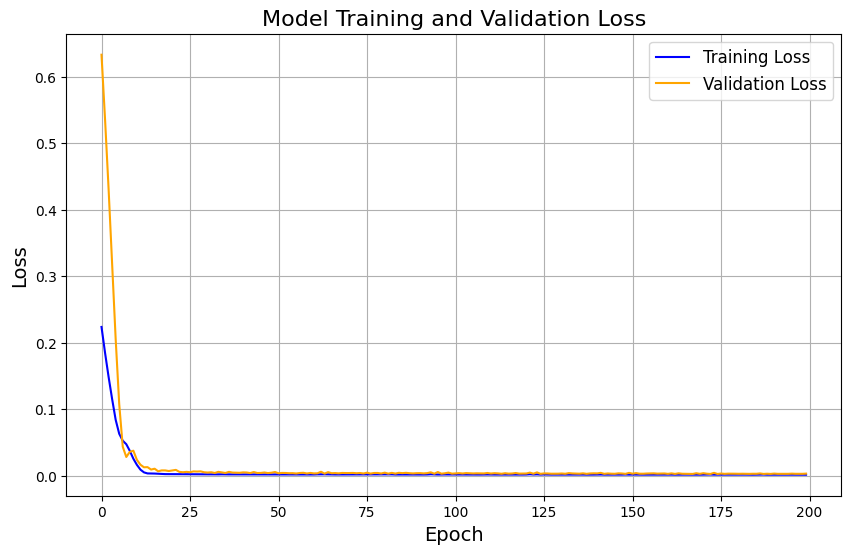

In [143]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [144]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [145]:
# Set pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.4f}'.format)


# Inverse transform predictions
train_predict_dummy = np.zeros((train_predict.shape[0], len(features) + 1))
test_predict_dummy = np.zeros((test_predict.shape[0], len(features) + 1))
train_predict_dummy[:, -1] = train_predict.flatten()
test_predict_dummy[:, -1] = test_predict.flatten()
train_predict = scaler.inverse_transform(train_predict_dummy)[:, -1]
test_predict = scaler.inverse_transform(test_predict_dummy)[:, -1]

# Prepare actual values
y_train_dummy = np.zeros((y_train.shape[0], len(features) + 1))
y_test_dummy = np.zeros((y_test.shape[0], len(features) + 1))
y_train_dummy[:, -1] = y_train
y_test_dummy[:, -1] = y_test
original_ytrain = scaler.inverse_transform(y_train_dummy)[:, -1]
original_ytest = scaler.inverse_transform(y_test_dummy)[:, -1]

print("\n10. Model Performance Metrics:")
metrics_train = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE %', 'R2', 'Explained Variance'],
    'Training': [
        math.sqrt(mean_squared_error(original_ytrain, train_predict)),
        mean_squared_error(original_ytrain, train_predict),
        mean_absolute_error(original_ytrain, train_predict),
        mean_absolute_percentage_error(original_ytrain, train_predict) * 100,
        r2_score(original_ytrain, train_predict),
        explained_variance_score(original_ytrain, train_predict)
    ]
})

metrics_test = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE %', 'R2', 'Explained Variance'],
    'Testing': [
        math.sqrt(mean_squared_error(original_ytest, test_predict)),
        mean_squared_error(original_ytest, test_predict),
        mean_absolute_error(original_ytest, test_predict),
        mean_absolute_percentage_error(original_ytest, test_predict) * 100,
        r2_score(original_ytest, test_predict),
        explained_variance_score(original_ytest, test_predict)
    ]
})

print("\nTraining Metrics:")
display(metrics_train.round(4))
print("\nTesting Metrics:")
display(metrics_test.round(4))


10. Model Performance Metrics:

Training Metrics:


,Metric,Training
0,RMSE,1946.0612
1,MSE,3787154.2522
2,MAE,1448.8447
3,MAPE %,1.9693
4,R2,0.9852
5,Explained Variance,0.9853



Testing Metrics:


,Metric,Testing
0,RMSE,2885.2376
1,MSE,8324596.0036
2,MAE,2336.8688
3,MAPE %,2.3550
4,R2,0.3691
5,Explained Variance,0.4863


In [151]:
print(f"\n SL: Stop Loss:\n SHORT(Actual Close and Actual Low > Entry price)\n LONG(Actual Close and Actual High < Entry price)")
print(f"\n CP: Close in Profit:\n SHORT(Actual Close  < Entry price)\n LONG(Actual close > Entry price)")
print(f"\n TP: Take Profit:\n SHORT(Actual low < Predicted Close	)\n LONG(Actual close > Predicted Close)")


 SL: Stop Loss:
 SHORT(Actual Close and Actual Low > Entry price)
 LONG(Actual Close and Actual High < Entry price)

 CP: Close in Profit:
 SHORT(Actual Close  < Entry price)
 LONG(Actual close > Entry price)

 TP: Take Profit:
 SHORT(Actual low < Predicted Close	)
 LONG(Actual close > Predicted Close)


In [166]:
# Leverage
leverage = 1
# Define the number of rows to display
#num_rows_to_display = 10

num_rows_to_display = test_data.shape[0]

# Use numpy slicing to get the entry point prices (formerly previous close)
entry_point = np.roll(original_ytest, shift=1)  # Shift elements by 1 position
entry_point[0] = np.nan  # Set the first element to NaN because it has no previous value

# Create the comparison table
comparison_table = pd.DataFrame({
    'Date': date_column[training_size + time_step:-1].reset_index(drop=True)[-len(test_predict):],
    'Entry Point': entry_point[-len(test_predict):],  # Previous Candle Close
    'Predicted Close': test_predict,
    'Actual High': maindf['High'][training_size + time_step:-1].reset_index(drop=True)[-len(test_predict):],
    'Actual Close': original_ytest,
    'Actual Low': maindf['Low'][training_size + time_step:-1].reset_index(drop=True)[-len(test_predict):],
})

# Add a column for the "LONG" or "SHORT" label
comparison_table['Signal'] = np.where(
    comparison_table['Predicted Close'] > comparison_table['Entry Point'],
    'LONG',
    'SHORT'
)

# Add a column for the "Result" based on Signal, Actual Close, and Actual High/Low
comparison_table['Result'] = np.where(
    (comparison_table['Signal'] == 'SHORT') & (comparison_table['Actual Low'] <= comparison_table['Predicted Close']),
    'TP',  # Take Profit (Signal: SHORT, Actual Low <= Predicted Close)
    np.where(
        (comparison_table['Signal'] == 'LONG') & (comparison_table['Actual High'] >= comparison_table['Predicted Close']),
        'TP',  # Take Profit (Signal: LONG, Actual High >= Predicted Close)
        np.where(
            (comparison_table['Signal'] == 'SHORT') & (comparison_table['Actual Low'] > comparison_table['Predicted Close']),
            np.where(
                comparison_table['Actual Close'] < comparison_table['Entry Point'],
                'CP',  # Close in Profit (Signal: SHORT, Actual Low > Predicted Close and Actual Close < Entry Point)
                'SL'  # Close in Loss (Signal: SHORT, Actual Low > Predicted Close and Actual Close > Entry Point)
            ),
            np.where(
                (comparison_table['Signal'] == 'LONG') & (comparison_table['Actual High'] < comparison_table['Predicted Close']),
                np.where(
                    comparison_table['Actual Close'] > comparison_table['Entry Point'],
                    'CP',  # Close in Profit (Signal: LONG, Actual High < Predicted Close and Actual Close > Entry Point)
                    'SL'  # Close in Loss (Signal: LONG, Actual High < Predicted Close and Actual Close < Entry Point)
                ),
                'Cancelled'  # Stop Loss (All other cases)
            )
        )
    )
)

# Calculate P Difference based on Result and Signal conditions
def calculate_p_difference(row):
    if row['Result'] == 'TP' and row['Signal'] == 'SHORT':
        return row['Entry Point'] - row['Predicted Close']
        #return row['Entry Point'] - row['Actual Close']
    elif row['Result'] == 'TP' and row['Signal'] == 'LONG':
        return row['Predicted Close'] - row['Entry Point']
        #return row['Actual Close'] - row['Entry Point']
    elif row['Result'] == 'CP' and row['Signal'] == 'SHORT':
        return row['Entry Point'] - row['Actual Close']
    elif row['Result'] == 'CP' and row['Signal'] == 'LONG':
        return row['Actual Close'] - row['Entry Point']
    elif row['Result'] == 'SL' and row['Signal'] == 'SHORT':
        return row['Entry Point'] - row['Actual Close']
    elif row['Result'] == 'SL' and row['Signal'] == 'LONG':
        return row['Actual Close'] - row['Entry Point']
    else:
        return np.nan

comparison_table['P Difference'] = comparison_table.apply(calculate_p_difference, axis=1)

# Calculate Difference % based on P Difference and Entry Point
comparison_table['Difference %'] = leverage * ((comparison_table['P Difference'] / comparison_table['Entry Point']) * 100 )
# Apply the condition to multiply by 2 if Difference % is less than 1%
#comparison_table['Difference %'] = comparison_table['Difference %'].apply(lambda x: x * 10 if abs(x) < 1 else x)

# Print the comparison table
print(f"\n11. Prediction Comparison (First {num_rows_to_display} rows):")
display(comparison_table.head(num_rows_to_display).round(2))



11. Prediction Comparison (First 19 rows):


,Date,Entry Point,Predicted Close,Actual High,Actual Close,Actual Low,Signal,Result,P Difference,Difference %
0,2025-01-04,NaN,96859.8600,98760.9000,98173.2000,97438.2000,SHORT,SL,NaN,NaN
1,2025-01-05,98173.2000,96711.7900,98852.6000,98340.2000,97227.0000,SHORT,SL,-167.0000,-0.1700
2,2025-01-06,98340.2000,96842.7900,102444.0000,102180.4000,97872.6000,SHORT,SL,-3840.2000,-3.9100
3,2025-01-07,102180.4000,100184.1300,102762.1000,96920.3000,96153.0000,SHORT,TP,1996.2700,1.9500
4,2025-01-08,96920.3000,97570.7600,97242.2000,95014.1000,92500.0000,LONG,SL,-1906.2000,-1.9700
5,2025-01-09,95014.1000,95635.1400,95358.7000,92505.9000,91055.8000,LONG,SL,-2508.2000,-2.6400
6,2025-01-10,92505.9000,93848.6600,95882.5000,94675.5000,92173.6000,LONG,TP,1342.7600,1.4500
7,2025-01-11,94675.5000,93824.5500,94988.0000,94562.5000,93802.1000,SHORT,TP,850.9500,0.9000
8,2025-01-12,94562.5000,93640.7600,95444.0000,94499.9000,93661.1000,SHORT,CP,62.6000,0.0700
9,2025-01-13,94499.9000,93584.9500,95934.5000,94485.3000,88909.0000,SHORT,TP,914.9500,0.9700


In [167]:
# Count the total trades hitting each result
result_counts = comparison_table['Result'].value_counts()

# Total number of trades
total_trades = len(comparison_table)

# Sum of P Difference and Difference %
total_p_difference = comparison_table['P Difference'].sum()
total_difference_percentage = comparison_table['Difference %'].sum()

# Win rate (TP + CP as wins, divided by total trades)
wins = result_counts.get('TP', 0) + result_counts.get('CP', 0)
win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0

# Maximum profit % in one trade (TP or CP)
max_profit_percentage = comparison_table.loc[
    comparison_table['Result'].isin(['TP', 'CP']), 'Difference %'
].max()

# Maximum loss % in one trade (SL)
max_loss_percentage = comparison_table.loc[
    comparison_table['Result'] == 'SL', 'Difference %'
].min()

# Calculate streaks of winning trades (TP or CP)
comparison_table['Winning'] = comparison_table['Result'].isin(['TP', 'CP'])
max_winning_streak = (
    comparison_table['Winning'].astype(int)
    .groupby((comparison_table['Winning'] != comparison_table['Winning'].shift()).cumsum())
    .cumsum()
    .max()
)

# Calculate streaks of losing trades (SL)
comparison_table['Losing'] = comparison_table['Result'] == 'SL'
max_losing_streak = (
    comparison_table['Losing'].astype(int)
    .groupby((comparison_table['Losing'] != comparison_table['Losing'].shift()).cumsum())
    .cumsum()
    .max()
)
# Prepare a summary dictionary for displaying results
summary = {
    "leverage": leverage,
    "Total Trades": total_trades,
    "TP (Take Profit)": result_counts.get('TP', 0),
    "CP (Close in Profit)": result_counts.get('CP', 0),
    "SL (Stop Loss)": result_counts.get('SL', 0),
    #print(f"Total P Difference: {total_p_difference:.2f}"),
    "ROI %": f"{total_difference_percentage:.2f}",
    "Win Rate %": f"{win_rate:.2f}",
    "Max Profit % in One Trade": f"{max_profit_percentage:.2f}",
    "Max Loss % in One Trade": f"{max_loss_percentage:.2f}",
    "Max Winning Streak": max_winning_streak,
    "Max Losing Streak": max_losing_streak,
}

# Display summary results
display(pd.DataFrame.from_dict(summary, orient="index", columns=["Value"]).rename_axis("Metric").reset_index())


,Metric,Value
0,leverage,1
1,Total Trades,17
2,TP (Take Profit),7
3,CP (Close in Profit),1
4,SL (Stop Loss),9
5,ROI %,-9.07
6,Win Rate %,47.06
7,Max Profit % in One Trade,2.75
8,Max Loss % in One Trade,-4.11
9,Max Winning Streak,4


In [168]:
# Create visualization
def plot_predictions(close_stock, train_predict, test_predict, date_column, time_step):
    trainPredictPlot = np.empty((len(close_stock), 1))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, 0] = train_predict

    testPredictPlot = np.empty((len(close_stock), 1))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1:len(close_stock)-1, 0] = test_predict

    plotdf = pd.DataFrame({
        'Date': close_stock['Open Time'],
        'Original Close': close_stock['Adj Close'],
        'Train Predicted Close': trainPredictPlot.flatten(),
        'Test Predicted Close': testPredictPlot.flatten()
    })

    fig = px.line(plotdf, x='Date',
                  y=['Original Close', 'Train Predicted Close', 'Test Predicted Close'],
                  title='Original vs Predicted Close Price')
    fig.show()

plot_predictions(close_stock, train_predict, test_predict, date_column, time_step)


In [113]:
model_save_directory = os.path.join(base_directory, 'FYP_Model_PipeLine')
model_save_path = os.path.join(model_save_directory, f"{model_name}.h5")  # Constructs the full save path
# Save the model
model.save(model_save_path)
print(f"\nModel saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/FYP_Model_PipeLine/BTC_4h.h5
